# Sistema de clasificación de electrodomésticos

Universidad Carlos III de Madrid

Autor: Gonzalo Soto Soto

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
filepath = 'C:\\Users\\Usuario\\Desktop\\UC3M\\TFG\\Dataset_v2_Consumers.xlsx'

#Cargamos el archivo de Excel
dataset = pd.read_excel(filepath, sheet_name=None);

In [3]:
dataset.keys()

dict_keys(['Consumer1', 'Consumer2', 'Consumer3', 'Consumer4', 'Consumer5', 'Consumer6', 'Consumer7', 'Consumer8', 'Consumer9', 'Consumer10', 'Consumer11', 'Consumer12', 'Consumer13', 'Consumer14', 'Consumer15', 'Consumer16', 'Consumer17', 'Consumer18', 'Consumer19', 'Consumer20', 'Consumer21', 'Consumer22', 'Consumer23', 'Consumer24', 'Consumer25', 'Consumer26', 'Consumer27', 'Consumer28', 'Consumer29', 'Consumer30', 'Consumer31', 'Consumer32', 'Consumer33', 'Consumer34', 'Consumer35', 'Consumer36', 'Consumer37', 'Consumer38', 'Consumer39', 'Consumer40', 'Consumer41', 'Consumer42', 'Consumer43', 'Consumer44', 'Consumer45', 'Consumer46', 'Consumer47', 'Consumer48', 'Consumer49', 'Consumer50'])

In [4]:
#Para ver como se estructuran los datos
dataset['Consumer46'].head()

,Unnamed: 0,Periods,Total Consumption,AC,Dish washer,Washing Machine,Dryer,Water heater,TV,Microwave,Kettle,Lighting,Refrigerator
0,0,1,0.924987,0,0.0,0.0,0.0,0.452,0.0,0.0,0.0,0.0,0.00
1,1,2,0.944434,0,0.0,0.0,0.0,0.128,0.0,0.0,0.0,0.0,0.14
2,2,3,0.962019,0,0.0,0.0,0.0,0.598,0.0,0.0,0.0,0.0,0.00
3,3,4,0.916855,0,0.0,0.0,0.0,0.230,0.0,0.0,0.0,0.0,0.00
4,4,5,0.940956,0,0.0,0.0,0.0,0.435,0.0,0.0,0.0,0.0,0.14


In [5]:
#Nos aseguramos de que todas las columnas tengan el tipo de correcto
dataset['Consumer46'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35136 entries, 0 to 35135
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         35136 non-null  int64  
 1   Periods            35136 non-null  int64  
 2   Total Consumption  35136 non-null  float64
 3   AC                 35136 non-null  int64  
 4   Dish washer        35136 non-null  float64
 5   Washing Machine    35136 non-null  float64
 6   Dryer              35136 non-null  float64
 7   Water heater       35136 non-null  float64
 8   TV                 35136 non-null  float64
 9   Microwave          35136 non-null  float64
 10  Kettle             35136 non-null  float64
 11  Lighting           35136 non-null  float64
 12  Refrigerator       35136 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 3.5 MB


# Extracción de características


In [6]:
#Funcion para cargar y procesar los datos
def extraccion_caracteristicas(dataset):

    #Nombres Columnas
    dataset.columns = ['Index','Periods', 'Total Consumption', 'AC', 'Dish washer', 'Washing Machine', 'Dryer', 'Water heater', 'TV', 'Microwave', 'Kettle', 'Lighting', 'Refrigerator']
    #Cogemos las columnas con valores relevantes
    electrodomesticos = dataset.loc[:, 'Dish washer':] 
    
    
    # Inicializar una lista para almacenar las cada bloque de 96 filas(1 dia ya que son periodos de 15 minutos)
    dias = []

    # Iterar sobre el DataFrame en bloques de 96 filas
    for i in range(0, len(electrodomesticos), 96):
        dia = electrodomesticos.iloc[i:i + 96]
        dias.append(dia)
        
        
    features = [] #Almacenar las caracteristicas
    labels = []   #Almacenar las etiquetas
    
    # Función para calcular la duración más larga en que un electrodoméstico esta encencendido sin apargarse
    def calcular_duracion_maxima_encendido(dia):
        max_duracion = 0  # Para almacenar la duración máxima encontrada
        duracion_actual = 0  # Para contar la duración de la secuencia actual de encendido

        for consumo in dia:
            if consumo > 0: 
                duracion_actual += 1 
            else:
                max_duracion = max(max_duracion, duracion_actual)  
                duracion_actual = 0  
                
        max_duracion = max(max_duracion, duracion_actual)

        return max_duracion
    
    #Iterar sobre los bloques (días) para y calcular el consumo total de cada electrodoméstico
    for dia in dias:
    
        consumo_maximo = dia.max() #VALOR MÁXIMO
        consumo_medio = dia.mean() #MEDIA ARITMETICA 
        duracion_ciclo_activo = (dia>0).sum() #Nº de periodos que el electrodomestico esta encendido
        suma_dia_electrodomestico = dia.sum() #CONSUMO TOTAL 
        desviacion_dia_electrodomestico = dia.std() #DESVIACION ESTANDAR
        umbral_50 = dia.max() * 0.5  #MUESTRAS POR ENCIMA DEL 50% del consumo maximo
        valores_sobre_50 = (dia > umbral_50).sum()
        varianza = dia.var() #VARIANZA
        cv = desviacion_dia_electrodomestico / consumo_medio #Coeficiente de variación
        duracion_maxima_encendido = dia.apply(calcular_duracion_maxima_encendido)  # Duración máxima de encendido continuo
        
        
        for electrodomestico in electrodomesticos.columns:
            entry = [
    
                consumo_maximo[electrodomestico],
                consumo_medio[electrodomestico],
                duracion_ciclo_activo[electrodomestico],
                suma_dia_electrodomestico[electrodomestico], 
                desviacion_dia_electrodomestico[electrodomestico], 
                valores_sobre_50[electrodomestico], 
                varianza[electrodomestico],
                cv[electrodomestico],
                duracion_maxima_encendido[electrodomestico],
            ]
            
            features.append(entry)
            labels.append(electrodomestico)

    # Convertir las características y etiquetas en un DataFrame
    df_features = pd.DataFrame(features, columns=['Consumo Maximo','Consumo Medio','Ciclos Activo','Consumo Total','Desviación','Umbral 50', 'Varianza','Coef Variación','Duración Máxima Encendido'])
    df_features['Electrodomestico'] = labels

    return df_features

In [7]:
# Procesar todas las hojas
dfs_features = []
for nombre_hoja, dataset in dataset.items():  
    print(f"Procesando {nombre_hoja}...")
    df_features = extraccion_caracteristicas(dataset)
    df_features['Consumer'] = nombre_hoja  # Añadir una columna para identificar el consumidor
    dfs_features.append(df_features)

# Combinar todos los DataFrames en uno solo
df_all_features = pd.concat(dfs_features, ignore_index=True)

Procesando Consumer1...
Procesando Consumer2...
Procesando Consumer3...
Procesando Consumer4...
Procesando Consumer5...
Procesando Consumer6...
Procesando Consumer7...
Procesando Consumer8...
Procesando Consumer9...
Procesando Consumer10...
Procesando Consumer11...
Procesando Consumer12...
Procesando Consumer13...
Procesando Consumer14...
Procesando Consumer15...
Procesando Consumer16...
Procesando Consumer17...
Procesando Consumer18...
Procesando Consumer19...
Procesando Consumer20...
Procesando Consumer21...
Procesando Consumer22...
Procesando Consumer23...
Procesando Consumer24...
Procesando Consumer25...
Procesando Consumer26...
Procesando Consumer27...
Procesando Consumer28...
Procesando Consumer29...
Procesando Consumer30...
Procesando Consumer31...
Procesando Consumer32...
Procesando Consumer33...
Procesando Consumer34...
Procesando Consumer35...
Procesando Consumer36...
Procesando Consumer37...
Procesando Consumer38...
Procesando Consumer39...
Procesando Consumer40...
Procesand

In [10]:
df_all_features

,Consumo Maximo,Consumo Medio,Ciclos Activo,Consumo Total,Desviación,Umbral 50,Varianza,Coef Variación,Duración Máxima Encendido,Electrodomestico,Consumer
0,2.257043,0.082288,8,7.899626,0.370696,4,0.137416,4.504877,6,Dish washer,Consumer1
1,1.887807,0.073378,12,7.044281,0.289018,4,0.083531,3.938757,6,Washing Machine,Consumer1
2,1.619519,0.048039,3,4.611769,0.269472,3,0.072615,5.609403,3,Dryer,Consumer1
3,1.016000,0.146813,33,14.094000,0.269868,12,0.072829,1.838182,11,Water heater,Consumer1
4,0.079383,0.008121,22,0.779656,0.016819,3,0.000283,2.071000,17,TV,Consumer1
...,...,...,...,...,...,...,...,...,...,...,...
164695,0.149450,0.012411,14,1.191452,0.035010,6,0.001226,2.820912,8,TV,Consumer50
164696,1.232000,0.025573,2,2.455000,0.176241,2,0.031061,6.891690,1,Microwave,Consumer50
164697,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,NaN,0,Kettle,Consumer50
164698,0.220000,0.034858,16,3.346333,0.079863,15,0.006378,2.291107,16,Lighting,Consumer50


In [11]:
# Eliminar filas donde todas las características sean cero
# Aquí, 'Electrodomestico' y 'Consumer' se excluyen de esta comprobación
df_all_features.fillna(0, inplace=True)
df_all_features_clean = df_all_features.loc[(df_all_features.drop(['Electrodomestico', 'Consumer'], axis=1) != 0).any(axis=1)]

# Verificar el tamaño del DataFrame después de la limpieza
print(f"Tamaño original del DataFrame (df_all_features): {df_all_features.shape}")
print(f"Tamaño del DataFrame después de eliminar filas con todos ceros (df_all_features_clean): {df_all_features_clean.shape}")

Tamaño original del DataFrame (df_all_features): (164700, 11)
Tamaño del DataFrame después de eliminar filas con todos ceros (df_all_features_clean): (118943, 11)


In [12]:
df_all_features_clean

,Consumo Maximo,Consumo Medio,Ciclos Activo,Consumo Total,Desviación,Umbral 50,Varianza,Coef Variación,Duración Máxima Encendido,Electrodomestico,Consumer
0,2.257043,0.082288,8,7.899626,0.370696,4,0.137416,4.504877,6,Dish washer,Consumer1
1,1.887807,0.073378,12,7.044281,0.289018,4,0.083531,3.938757,6,Washing Machine,Consumer1
2,1.619519,0.048039,3,4.611769,0.269472,3,0.072615,5.609403,3,Dryer,Consumer1
3,1.016000,0.146813,33,14.094000,0.269868,12,0.072829,1.838182,11,Water heater,Consumer1
4,0.079383,0.008121,22,0.779656,0.016819,3,0.000283,2.071000,17,TV,Consumer1
...,...,...,...,...,...,...,...,...,...,...,...
164694,0.373000,0.031406,12,3.015000,0.093421,9,0.008728,2.974607,4,Water heater,Consumer50
164695,0.149450,0.012411,14,1.191452,0.035010,6,0.001226,2.820912,8,TV,Consumer50
164696,1.232000,0.025573,2,2.455000,0.176241,2,0.031061,6.891690,1,Microwave,Consumer50
164698,0.220000,0.034858,16,3.346333,0.079863,15,0.006378,2.291107,16,Lighting,Consumer50


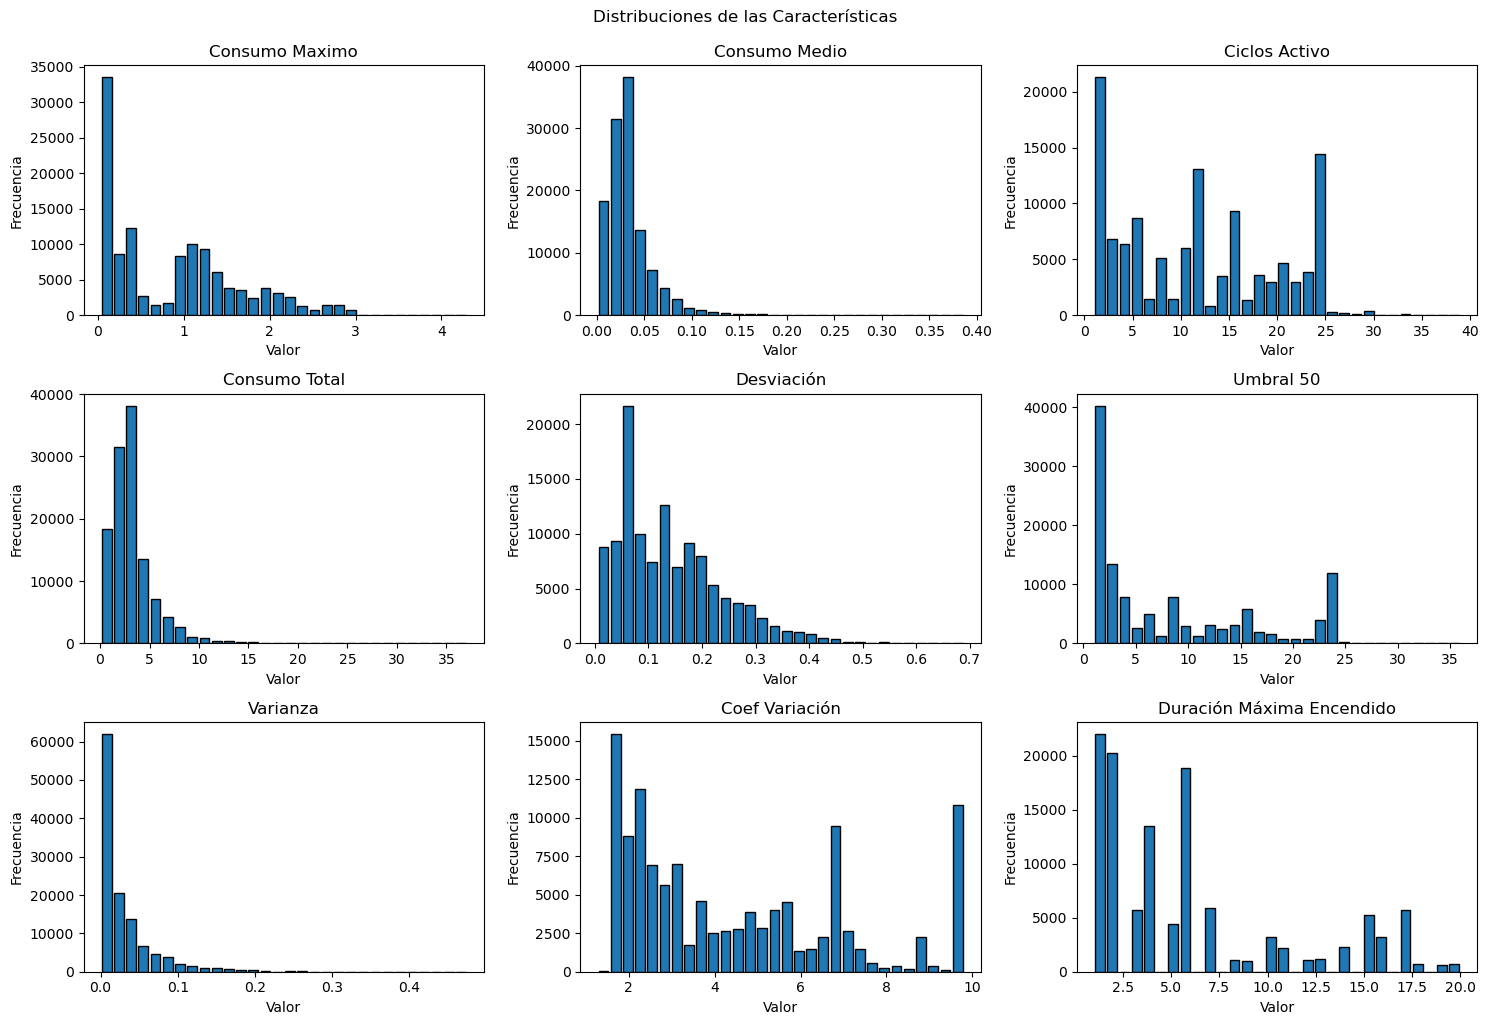

In [18]:
def graficar_distribuciones(df_all_features_clean):
    features = df_all_features_clean.drop(['Electrodomestico', 'Consumer'], axis=1).columns  # Obtén las características sin la etiqueta
    plt.figure(figsize=(15, 10))  # Define el tamaño de la figura

    # Graficar cada característica por separado
    for i, feature in enumerate(features): 
        plt.subplot(3, 3, i + 1 )  
        plt.hist(df_all_features_clean[feature], bins=30, rwidth=0.8, edgecolor='black')
        plt.title(feature)
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.suptitle('Distribuciones de las Características', y=1.02)  # Añadir título general
    plt.show()

graficar_distribuciones(df_all_features_clean)


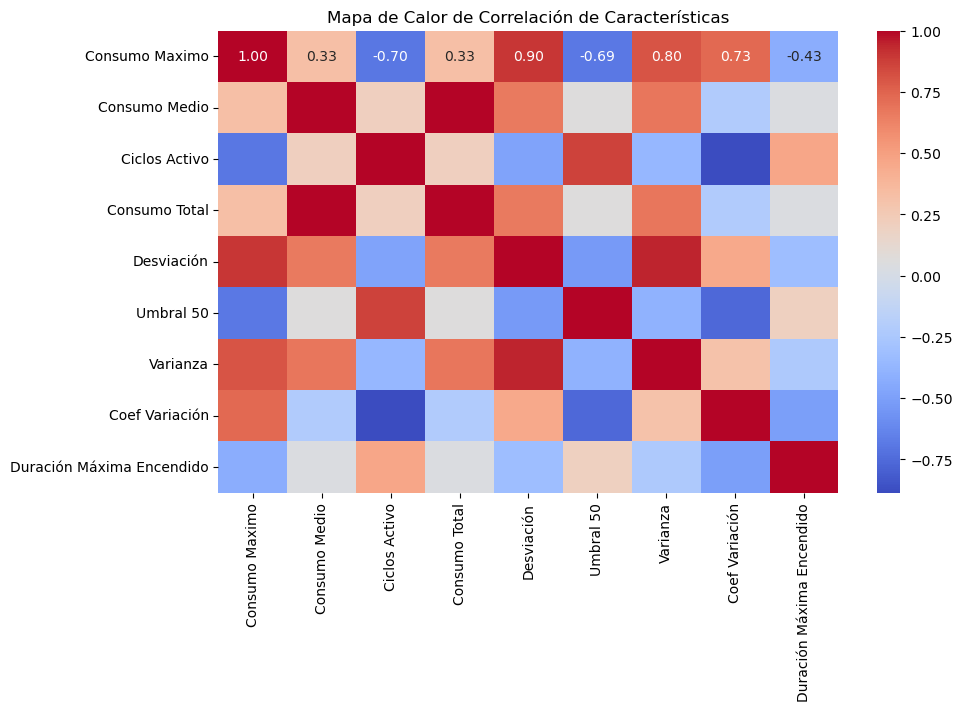

In [20]:
#Mapas de calor de correlación
#Para entender cómo se relacionan las características entre sí
import seaborn as sns
def graficar_correlacion(df_all_features_clean):
    plt.figure(figsize=(10, 6))
    correlation_matrix = df_all_features_clean.drop(['Electrodomestico','Consumer'], axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Mapa de Calor de Correlación de Características')
    plt.show()

graficar_correlacion(df_all_features_clean)

# Creación de los modelos

In [21]:
#Definimos los modelos y los parámteros que queremos probar
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

modelos_parametros = {
    'KNeighborsClassifier': { 
        'modelo': KNeighborsClassifier(), 
        'parametros': {
            'n_neighbors': [3, 5, 7, 10, 15],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'RandomForestClassifier':{
        'modelo' : RandomForestClassifier(),
        'parametros' : {
            'n_estimators': [50,100], 
            'max_depth' : [5,10,20], 
            'criterion' : ['gini','entropy'],
            'min_samples_split' : [2,5], 
            'min_samples_leaf': [2,4] 
        }
    },
    'SVM':{
        'modelo' : SVC(),
        'parametros' : {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': [0.001,0.01, 1]
        }
    },
    'MLPClassifier':{
        'modelo' : MLPClassifier(verbose=True),
        'parametros' : {
            'hidden_layer_sizes': [(50,), (100,)], 
            'alpha': [0.0001, 0.001], 
            'max_iter': [200,300] 
        }
    }
}


# Entrenamiento y Evaluación de los modelos

In [22]:
def probar_modelos(df_features, modelos_parametros):

    X = df_all_features_clean.drop(['Electrodomestico','Consumer'], axis=1) 
    y = df_all_features_clean['Electrodomestico']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #Estandarizamos los datos
    scaler = StandardScaler() 
    scaler.fit(X_train) 
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    #Probando los distintos modelos
    for nombre_modelo, modelo_params in modelos_parametros.items(): 
        
        print(f"\nProbando {nombre_modelo}...")
        modelo = modelo_params['modelo'] 
        parametros = modelo_params.get('parametros',{})
        
        #Buscamos los mejores valores para cada hiperparametro
        grid_search = GridSearchCV(
            estimator=modelo,
            param_grid=parametros,
            scoring='accuracy', 
            cv = 5, 
            error_score='raise',
            n_jobs=-1  
        )
        
        # Ajustar el modelo
        grid_search.fit(X_train_scaled, y_train)
        
        # Obtener los mejores parámetros y el mejor modelo
        mejor_modelo = grid_search.best_estimator_
        print(f"Mejores parámetros para {nombre_modelo}: {grid_search.best_params_}")

        # Evaluar el modelo con los datos de prueba
        y_pred = mejor_modelo.predict(X_test_scaled)
        print(f"Precisión para {nombre_modelo}: {accuracy_score(y_test, y_pred)}")
        print(f"Informe de clasificación para {nombre_modelo}:\n{classification_report(y_test, y_pred)}")
        print(f"Matriz de confusión para {nombre_modelo}:\n{confusion_matrix(y_test, y_pred)}")
        print("----------------------------")
    

In [23]:
probar_modelos(df_all_features, modelos_parametros)


Probando KNeighborsClassifier...
Mejores parámetros para KNeighborsClassifier: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Precisión para KNeighborsClassifier: 0.9954039738811199
Informe de clasificación para KNeighborsClassifier:
                 precision    recall  f1-score   support

    Dish washer       0.98      0.98      0.98      3184
          Dryer       1.00      1.00      1.00      2655
         Kettle       0.99      0.99      0.99      2151
       Lighting       1.00      1.00      1.00      2956
      Microwave       1.00      1.00      1.00      4147
   Refrigerator       1.00      1.00      1.00      5354
             TV       1.00      1.00      1.00      5376
Washing Machine       0.99      0.98      0.99      4744
   Water heater       1.00      1.00      1.00      5116

       accuracy                           1.00     35683
      macro avg       0.99      0.99      0.99     35683
   weighted avg       1.00      1.00      1.00     35683

Matriz de confusió

Iteration 118, loss = 0.07154417
Iteration 119, loss = 0.07133595
Iteration 120, loss = 0.07116912
Iteration 121, loss = 0.07121240
Iteration 122, loss = 0.07118250
Iteration 123, loss = 0.07151173
Iteration 124, loss = 0.07086926
Iteration 125, loss = 0.07071424
Iteration 126, loss = 0.07029337
Iteration 127, loss = 0.07054496
Iteration 128, loss = 0.07035794
Iteration 129, loss = 0.07061223
Iteration 130, loss = 0.07046346
Iteration 131, loss = 0.06999252
Iteration 132, loss = 0.07007469
Iteration 133, loss = 0.06980156
Iteration 134, loss = 0.06992818
Iteration 135, loss = 0.06992752
Iteration 136, loss = 0.06950677
Iteration 137, loss = 0.06950928
Iteration 138, loss = 0.06989764
Iteration 139, loss = 0.06931761
Iteration 140, loss = 0.06919993
Iteration 141, loss = 0.06937998
Iteration 142, loss = 0.06895630
Iteration 143, loss = 0.06931193
Iteration 144, loss = 0.06883091
Iteration 145, loss = 0.06838869
Iteration 146, loss = 0.06862179
Iteration 147, loss = 0.06922271
Iteration 